In [5]:
# --- Cell 1: Import Libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import itertools

In [7]:
# --- Cell 2: Fetch Data ---
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'
data = yf.download(tickers, start=start_date, end=end_date)['Close']


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\2044442525.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [8]:

# --- Cell 3: Helper Function ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [9]:

# --- Cell 4: Model and Plot Function ---
def run_models_and_plot(asset, ticker):
    train = asset[:'2023-12-31']
    test = asset['2024-01-01':]

    # ARIMA Grid Search
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    best_score, best_cfg = float("inf"), None
    for param in pdq:
        try:
            model = ARIMA(train, order=param)
            results = model.fit()
            pred = results.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, pred))
            if rmse < best_score:
                best_score, best_cfg = rmse, param
        except:
            continue

    # Fit Best ARIMA & Forecast
    model = ARIMA(train, order=best_cfg)
    results = model.fit()
    arima_pred = results.forecast(steps=len(test))

    # Plot ARIMA
    plt.figure(figsize=(12,5))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, arima_pred, label='ARIMA Forecast', color='red')
    plt.legend()
    plt.title(f'{ticker} ARIMA Forecast')
    plt.show()

    # LSTM Preparation
    scaler = MinMaxScaler()
    asset_scaled = scaler.fit_transform(asset.values.reshape(-1,1))
    train_size = len(train)
    train_scaled = asset_scaled[:train_size]
    test_scaled = asset_scaled[train_size:]

    seq_length = 30
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # LSTM Grid Search
    best_lstm_score = float("inf")
    best_lstm_cfg = None
    for units in [32, 64]:
        for batch_size in [16, 32]:
            model = Sequential()
            model.add(LSTM(units, input_shape=(seq_length, 1)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)
            pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            if rmse < best_lstm_score:
                best_lstm_score = rmse
                best_lstm_cfg = (units, batch_size)

    # Fit Best LSTM & Forecast
    model = Sequential()
    model.add(LSTM(best_lstm_cfg[0], input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=best_lstm_cfg[1], verbose=0)
    lstm_pred = model.predict(X_test)
    lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
    test_actual_rescaled = scaler.inverse_transform(y_test)

    # Plot LSTM
    plt.figure(figsize=(12,5))
    plt.plot(train.index, scaler.inverse_transform(train_scaled), label='Train', color='blue')
    plt.plot(test.index, scaler.inverse_transform(test_scaled), label='Test', color='green')
    plt.plot(test.index[seq_length:], lstm_pred_rescaled, label='LSTM Forecast', color='orange')
    plt.legend()
    plt.title(f'{ticker} LSTM Forecast')
    plt.show()

    # Metrics Comparison
    arima_mae = mean_absolute_error(test, arima_pred)
    arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
    arima_mape = mape(test, arima_pred)

    lstm_mae = mean_absolute_error(test_actual_rescaled, lstm_pred_rescaled)
    lstm_rmse = np.sqrt(mean_squared_error(test_actual_rescaled, lstm_pred_rescaled))
    lstm_mape = mape(test_actual_rescaled, lstm_pred_rescaled)

    print(f"{ticker} ARIMA MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}")
    print(f"{ticker} LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}")


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\


--- TSLA ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

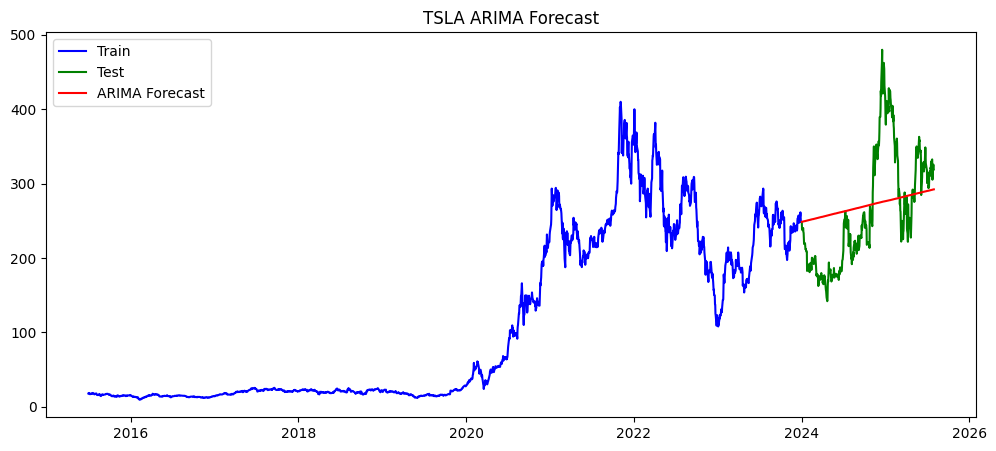

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


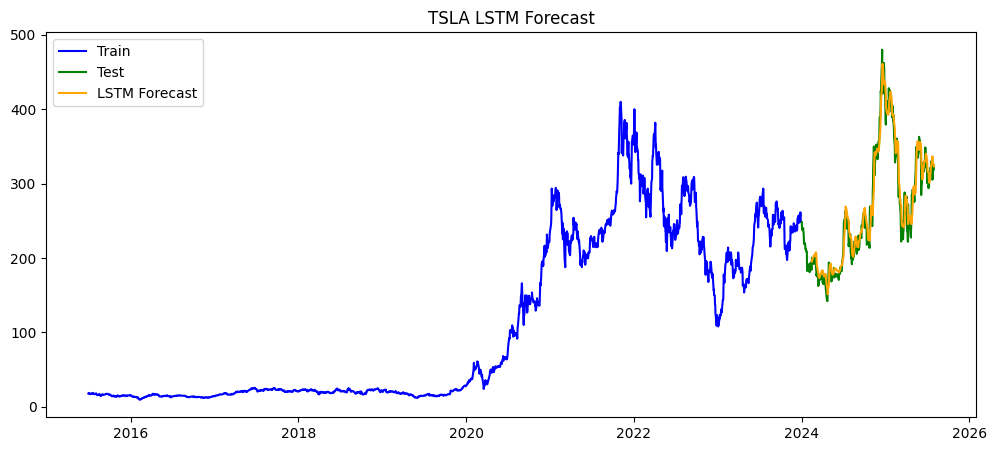

C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:28: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundati

TSLA ARIMA MAE: 57.89, RMSE: 69.18, MAPE: nan
TSLA LSTM MAE: 12.50, RMSE: 16.28, MAPE: 4.84

--- BND ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

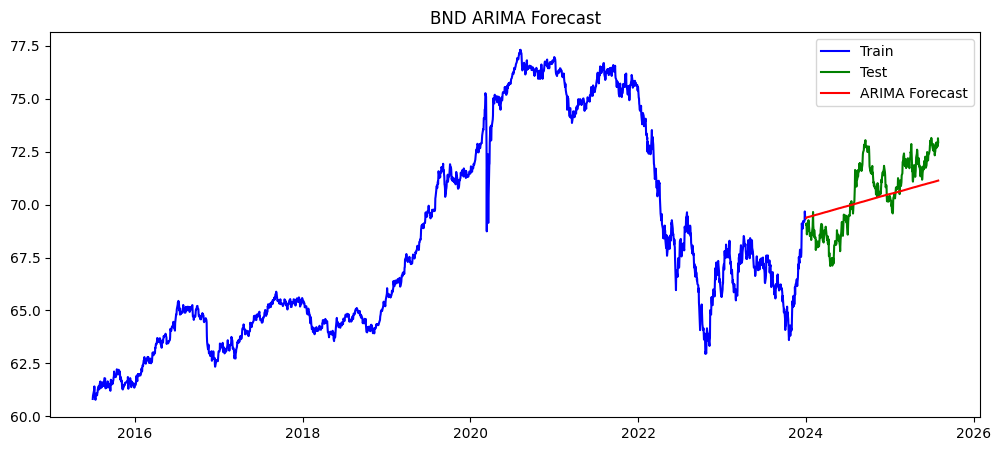

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


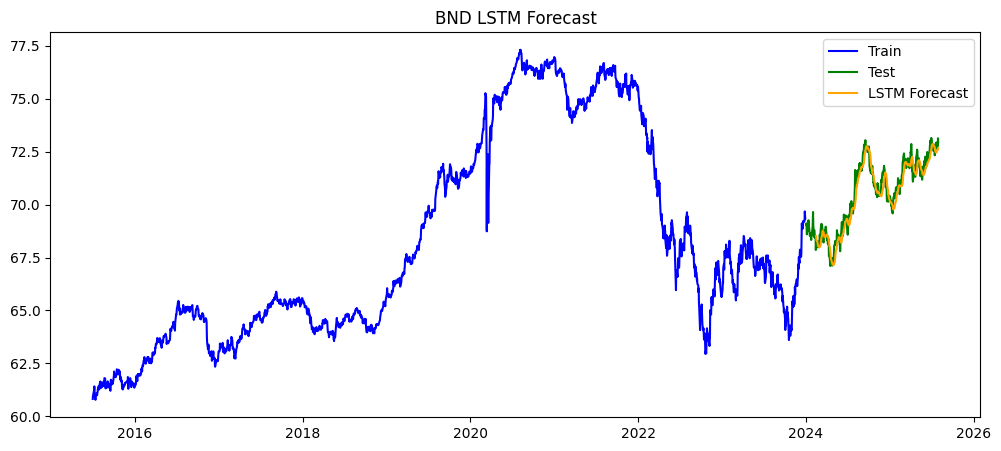

C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:28: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundati

BND ARIMA MAE: 1.10, RMSE: 1.28, MAPE: nan
BND LSTM MAE: 0.34, RMSE: 0.42, MAPE: 0.48

--- SPY ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

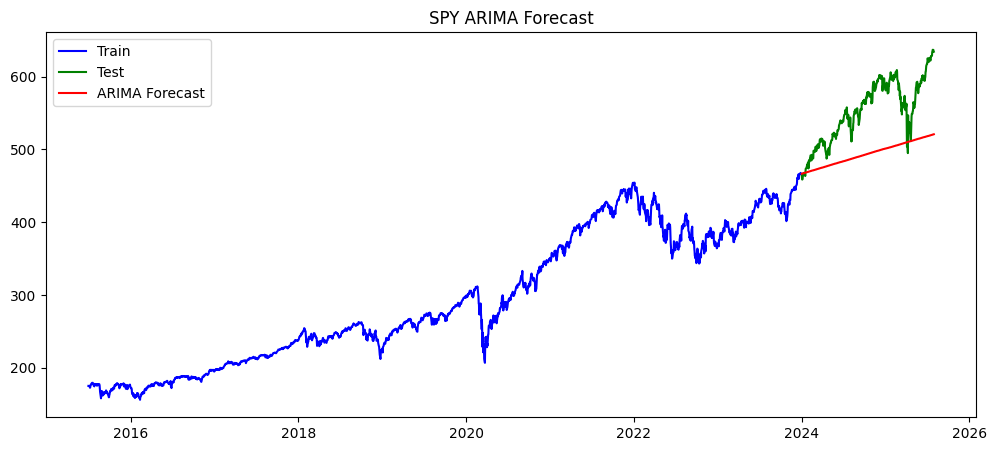

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


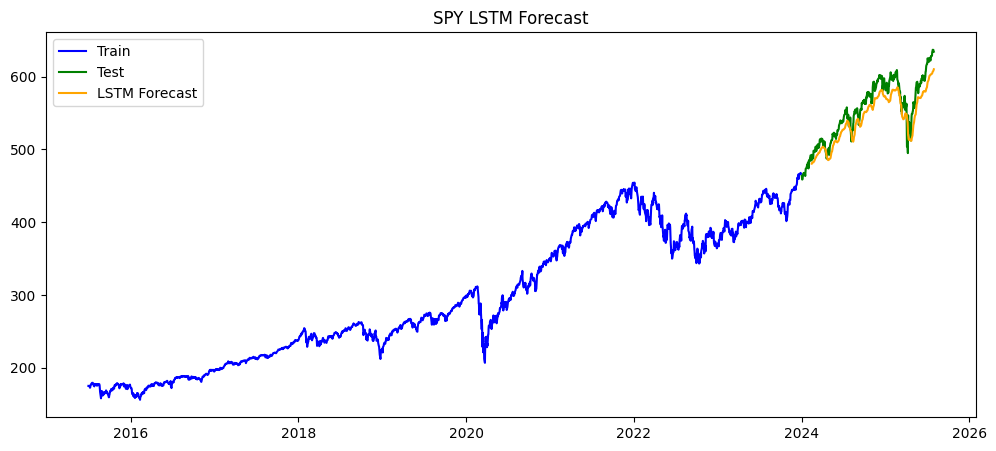

SPY ARIMA MAE: 59.01, RMSE: 66.19, MAPE: nan
SPY LSTM MAE: 16.75, RMSE: 18.66, MAPE: 2.96


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:28: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
for ticker in tickers:
    print(f"\n--- {ticker} ---")
    asset = data[ticker].dropna()
    run_models_and_plot(asset, ticker)


--- TSLA Forecast from 2025-08-01 ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

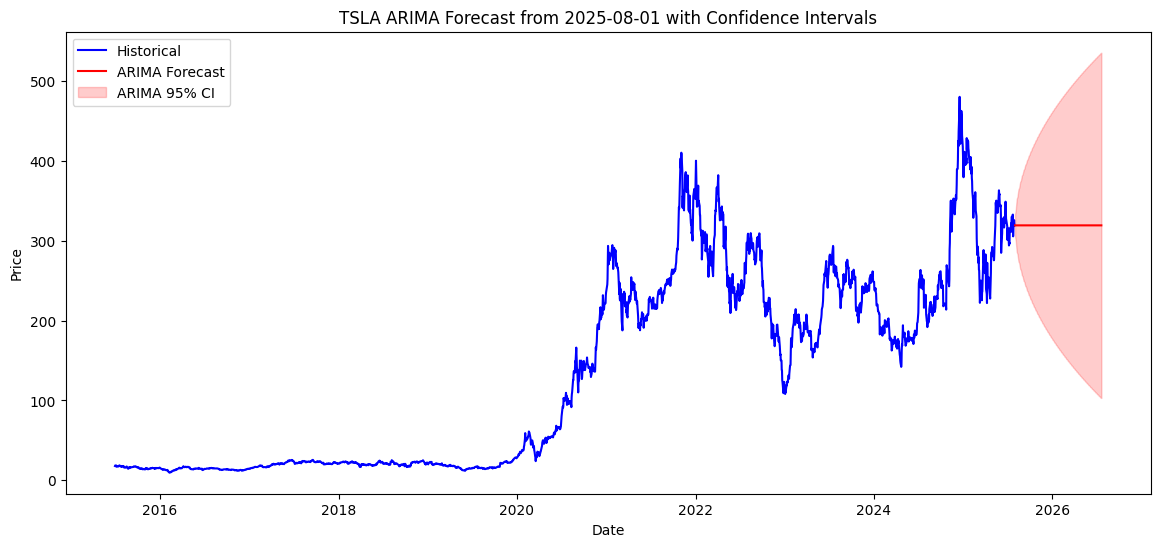

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- BND Forecast from 2025-08-01 ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

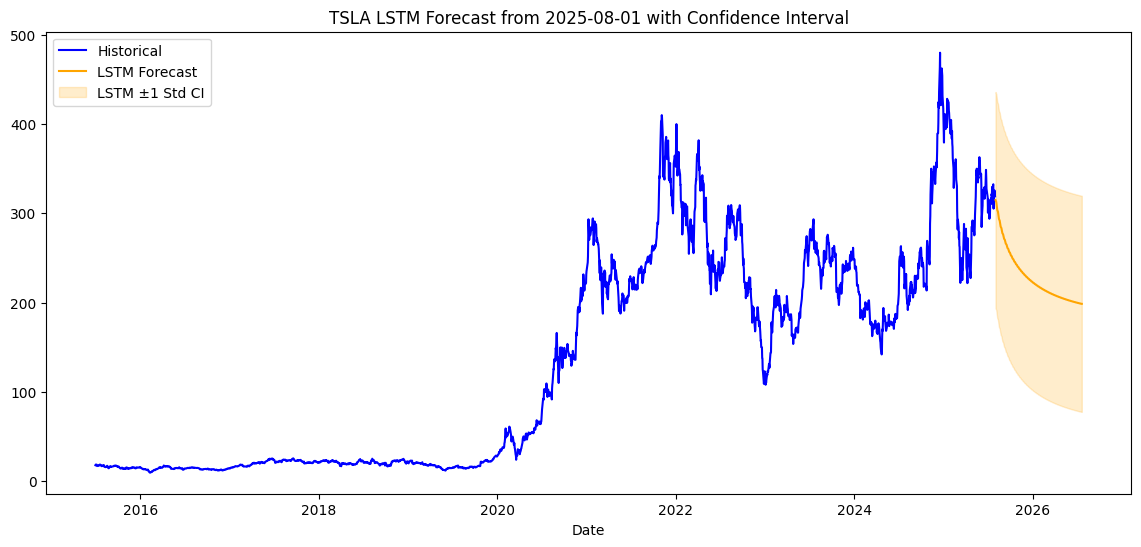

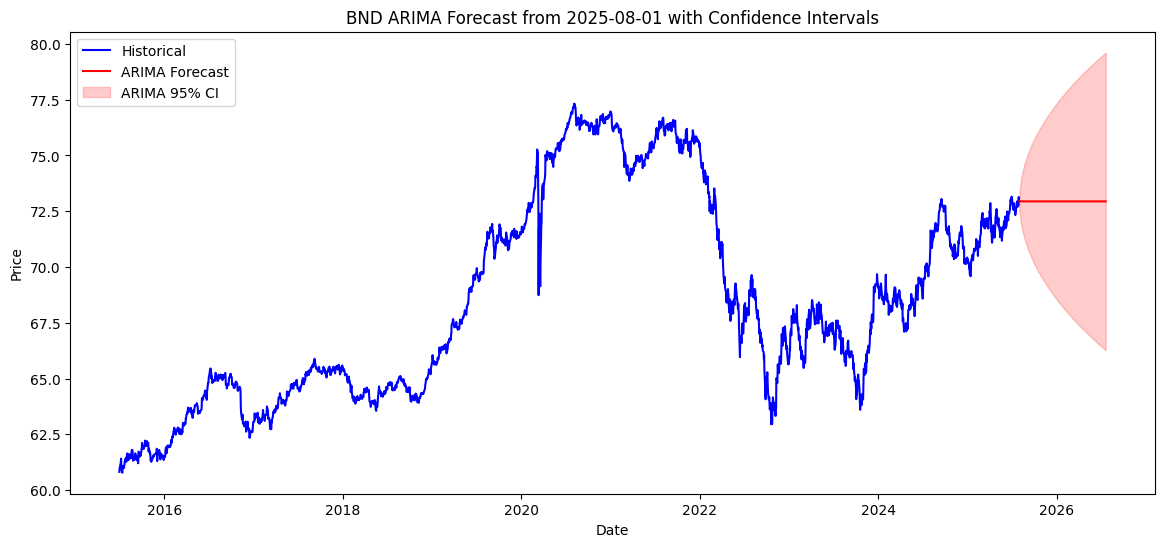

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- SPY Forecast from 2025-08-01 ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

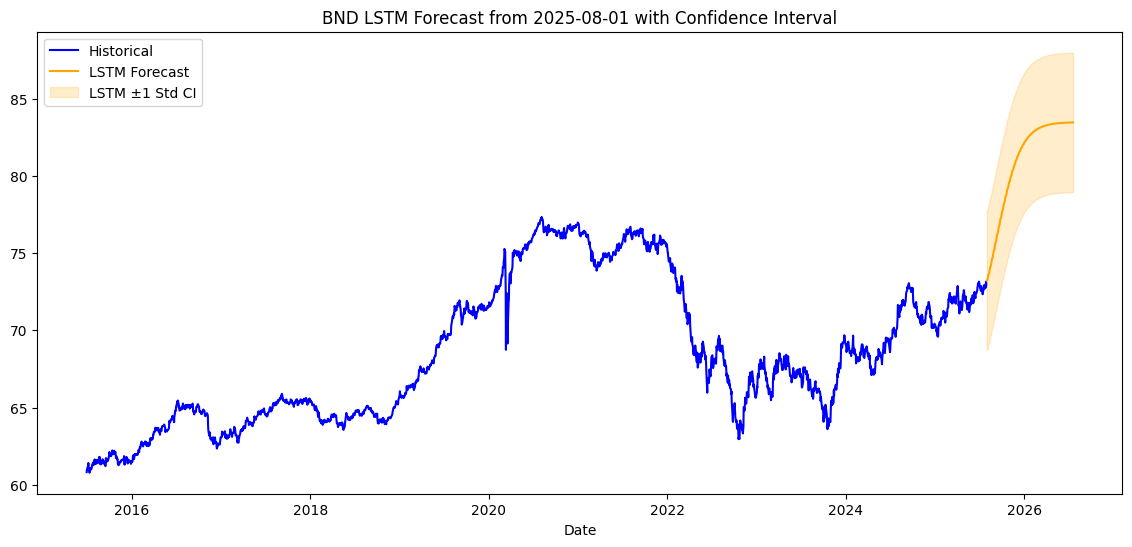

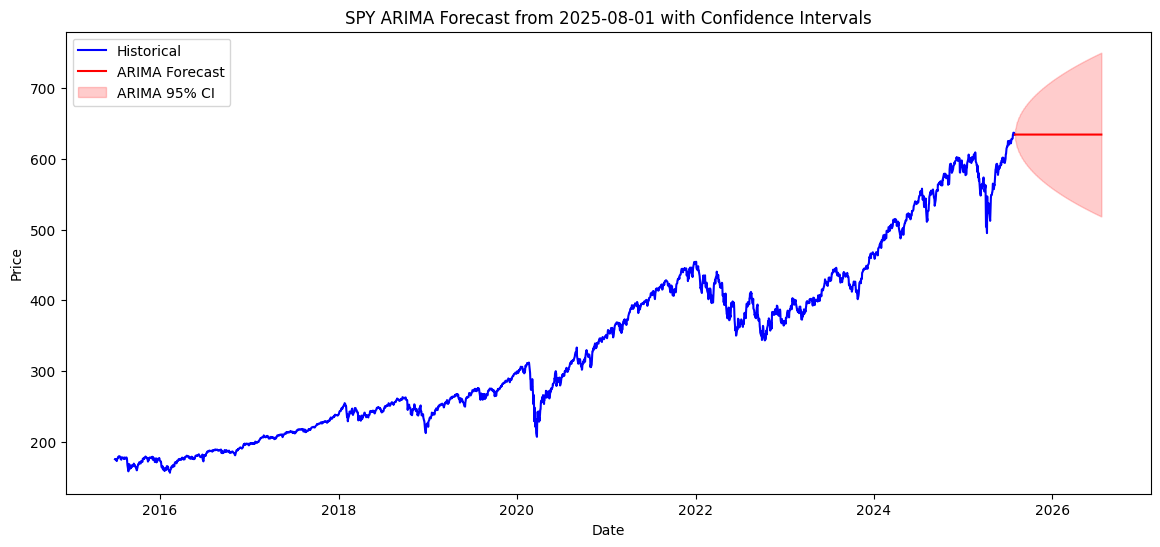

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


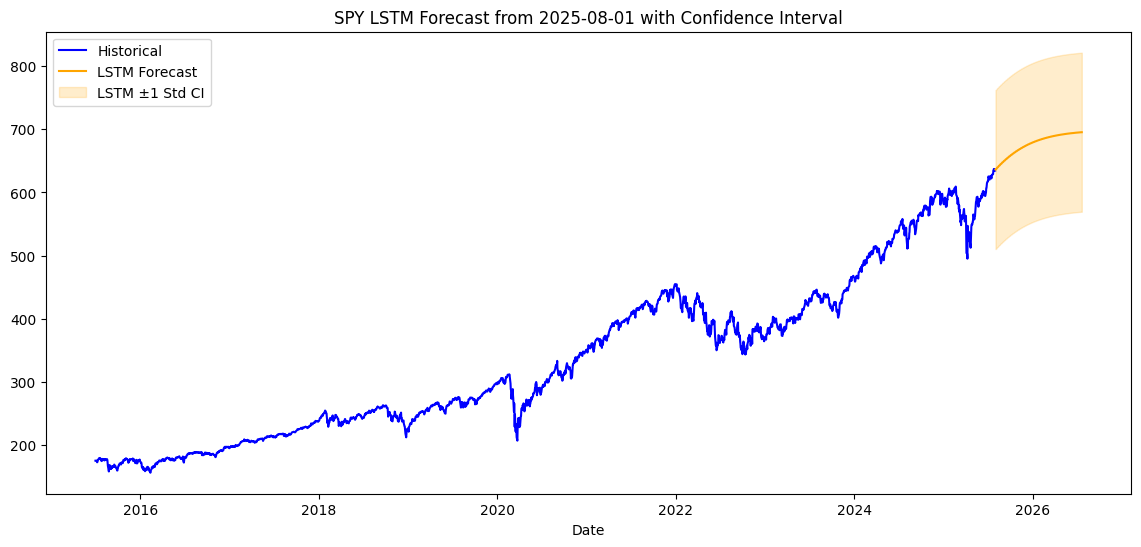

In [11]:
# --- Cell: Forecast from 2025-08-01 for All Assets in tickers ---

forecast_steps = 252  # Approx. 12 months of trading days
seq_length = 30

for ticker in tickers:
    print(f"\n--- {ticker} Forecast from 2025-08-01 ---")
    asset = data[ticker].dropna()
    train = asset[:'2025-07-31']

    # --- ARIMA Forecast ---
    try:
        model = ARIMA(train, order=(1,1,1))
        results = model.fit()
        arima_forecast = results.get_forecast(steps=forecast_steps)
        arima_pred = arima_forecast.predicted_mean
        arima_ci = arima_forecast.conf_int()
    except Exception as e:
        print(f"ARIMA failed for {ticker}: {e}")
        continue

    last_date = pd.to_datetime('2025-07-31')
    future_dates = pd.date_range(last_date, periods=forecast_steps+1, freq='B')[1:]

    plt.figure(figsize=(14,6))
    plt.plot(asset.index, asset, label='Historical', color='blue')
    plt.plot(future_dates, arima_pred, label='ARIMA Forecast', color='red')
    plt.fill_between(future_dates, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='red', alpha=0.2, label='ARIMA 95% CI')
    plt.legend()
    plt.title(f'{ticker} ARIMA Forecast from 2025-08-01 with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    # --- LSTM Forecast (same architecture for all tickers) ---
    scaler = MinMaxScaler()
    asset_scaled = scaler.fit_transform(asset.values.reshape(-1,1))
    train_scaled = asset_scaled[:len(train)]

    X_train, y_train = create_sequences(train_scaled, seq_length)

    model_lstm = Sequential()
    model_lstm.add(LSTM(64, input_shape=(seq_length, 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    lstm_forecast_scaled = []
    last_seq = train_scaled[-seq_length:]
    for _ in range(forecast_steps):
        pred = model_lstm.predict(last_seq.reshape(1, seq_length, 1), verbose=0)
        lstm_forecast_scaled.append(pred[0,0])
        last_seq = np.append(last_seq[1:], pred[0,0])

    lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1,1)).flatten()

    # Calculate naive confidence intervals for LSTM (±1 std of train set, for illustration)
    lstm_std = np.std(scaler.inverse_transform(y_train))
    lstm_upper = lstm_forecast + lstm_std
    lstm_lower = lstm_forecast - lstm_std

    plt.figure(figsize=(14,6))
    plt.plot(asset.index, asset, label='Historical', color='blue')
    plt.plot(future_dates, lstm_forecast, label='LSTM Forecast', color='orange')
    plt.fill_between(future_dates, lstm_lower, lstm_upper, color='orange', alpha=0.2, label='LSTM ±1 Std CI')
    plt.legend()
    plt.title(f'{ticker} LSTM Forecast from 2025-08-01 with Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel

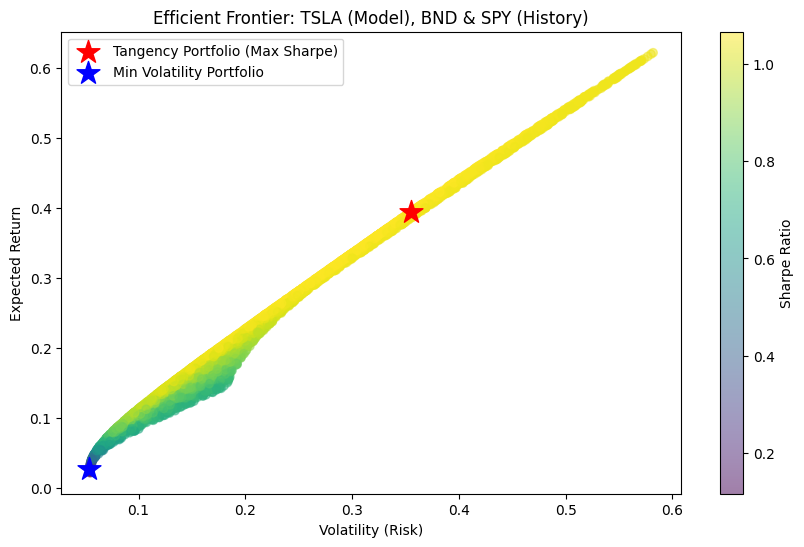

Tangency Portfolio (Maximum Sharpe Ratio):
Weights: TSLA=0.51, BND=0.00, SPY=0.48
Expected Annual Return: 39.36%
Volatility: 35.50%
Sharpe Ratio: 1.07

Minimum Volatility Portfolio:
Weights: TSLA=0.00, BND=0.95, SPY=0.05
Expected Annual Return: 2.65%
Volatility: 5.40%
Sharpe Ratio: 0.21


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Expected returns (annualized)
tsla_expected_annual = returns['TSLA'][-252:].mean() * 252  # Use model forecast if available
bnd_expected_annual = returns['BND'].mean() * 252
spy_expected_annual = returns['SPY'].mean() * 252
expected_returns = np.array([tsla_expected_annual, bnd_expected_annual, spy_expected_annual])

# 2. Covariance matrix (annualized)
cov_matrix = returns[['TSLA', 'BND', 'SPY']].cov() * 252

# 3. Portfolio math
def portfolio_performance(weights, mean_returns, cov_matrix, rf=0.015):
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - rf) / std
    return ret, std, sharpe

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf=0.015):
    return -portfolio_performance(weights, mean_returns, cov_matrix, rf)[2]

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# 4. Efficient Frontier simulation
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    weights_record.append(weights)
    ret, vol, sharpe = portfolio_performance(weights, expected_returns, cov_matrix)
    results[0,i] = ret
    results[1,i] = vol
    results[2,i] = sharpe

# 5. Optimization for tangency (max Sharpe) and min volatility
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for _ in range(3))
init_guess = [1/3, 1/3, 1/3]

max_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=cons)
min_vol = minimize(portfolio_volatility, init_guess, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=cons)

max_sharpe_weights = max_sharpe.x
min_vol_weights = min_vol.x

max_sharpe_ret, max_sharpe_vol, max_sharpe_sr = portfolio_performance(max_sharpe_weights, expected_returns, cov_matrix)
min_vol_ret, min_vol_vol, min_vol_sr = portfolio_performance(min_vol_weights, expected_returns, cov_matrix)

# 6. Plot Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier: TSLA (Model), BND & SPY (History)')
plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='*', color='r', s=300, label='Tangency Portfolio (Max Sharpe)')
plt.scatter(min_vol_vol, min_vol_ret, marker='*', color='b', s=300, label='Min Volatility Portfolio')
plt.legend()
plt.show()

# 7. Recommendation
print("Tangency Portfolio (Maximum Sharpe Ratio):")
print(f"Weights: TSLA={max_sharpe_weights[0]:.2f}, BND={max_sharpe_weights[1]:.2f}, SPY={max_sharpe_weights[2]:.2f}")
print(f"Expected Annual Return: {max_sharpe_ret:.2%}")
print(f"Volatility: {max_sharpe_vol:.2%}")
print(f"Sharpe Ratio: {max_sharpe_sr:.2f}")

print("\nMinimum Volatility Portfolio:")
print(f"Weights: TSLA={min_vol_weights[0]:.2f}, BND={min_vol_weights[1]:.2f}, SPY={min_vol_weights[2]:.2f}")
print(f"Expected Annual Return: {min_vol_ret:.2%}")
print(f"Volatility: {min_vol_vol:.2%}")
print(f"Sharpe Ratio: {min_vol_sr:.2f}")


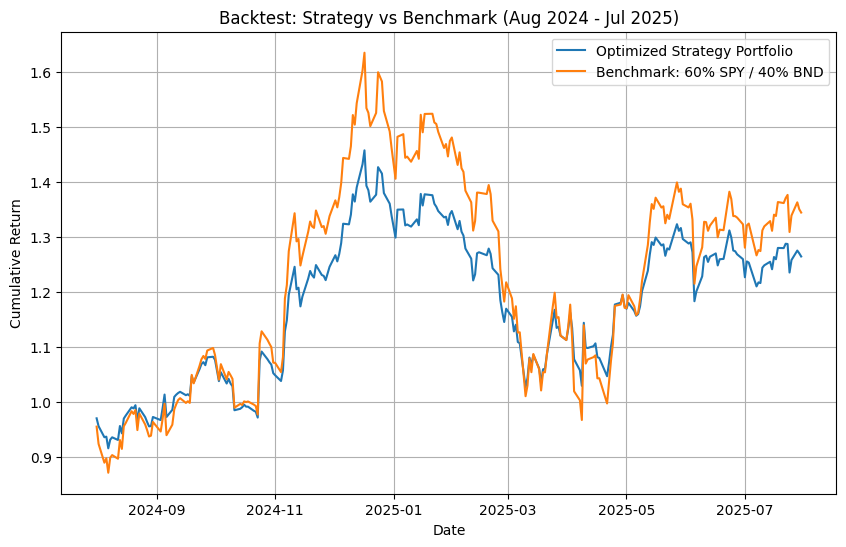

Strategy Portfolio Total Return: 26.46%
Strategy Portfolio Sharpe Ratio: 0.81
Benchmark Portfolio Total Return: 34.45%
Benchmark Portfolio Sharpe Ratio: 0.82

Result: Your optimized strategy did not outperform the benchmark in this backtest.


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\1165014173.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = strategy_cum[-1] - 1
C:\Users\hp\AppData\Local\Temp\ipykernel_21512\1165014173.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_total_return = benchmark_cum[-1] - 1


In [ ]:
# --- Task 5: Strategy Backtesting ---

# 1. Define Backtesting Period
backtest_start = '2024-08-01'
backtest_end = '2025-07-31'
backtest_returns = returns.loc[backtest_start:backtest_end]

# 2. Define Benchmark Portfolio (60% SPY, 40% BND)
benchmark_weights = np.array([0, 0.4, 0.6])  # [TSLA, BND, SPY]
benchmark_daily = (backtest_returns * benchmark_weights).sum(axis=1)
benchmark_cum = (1 + benchmark_daily).cumprod()

# 3. Simulate Strategy Portfolio (hold optimal weights for full year)
strategy_weights = max_sharpe_weights
strategy_daily = (backtest_returns * strategy_weights).sum(axis=1)
strategy_cum = (1 + strategy_daily).cumprod()

# 4. Plot cumulative returns
plt.figure(figsize=(10,6))
plt.plot(strategy_cum, label='Optimized Strategy Portfolio')
plt.plot(benchmark_cum, label='Benchmark: 60% SPY / 40% BND')
plt.title('Backtest: Strategy vs Benchmark (Aug 2024 - Jul 2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# 5. Calculate Sharpe Ratio and Total Return
def sharpe_ratio(returns, rf=0.015):
    ann_return = np.mean(returns) * 252
    ann_vol = np.std(returns) * np.sqrt(252)
    return (ann_return - rf) / ann_vol

strategy_total_return = strategy_cum[-1] - 1
benchmark_total_return = benchmark_cum[-1] - 1
strategy_sharpe = sharpe_ratio(strategy_daily)
benchmark_sharpe = sharpe_ratio(benchmark_daily)

print(f"Strategy Portfolio Total Return: {strategy_total_return:.2%}")
print(f"Strategy Portfolio Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"Benchmark Portfolio Total Return: {benchmark_total_return:.2%}")
print(f"Benchmark Portfolio Sharpe Ratio: {benchmark_sharpe:.2f}")

# 6. Summary
if strategy_total_return > benchmark_total_return:
    print("\nResult: Your optimized strategy outperformed the benchmark in this backtest.")
else:
    print("\nResult: Your optimized strategy did not outperform the benchmark in this backtest.")